<a href="https://colab.research.google.com/github/NachoDave/Automated-Vehicle-Anomalous-Driving-Behaviour/blob/main/CAMs_Autoencoder_project_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Autoencoder project

## What do we need to do?


1.   Get and format the data
2.   Split the data into training, test and validation sets - initially will just add the data one measure at a time, but may need to combine them somehow
3. Define the model
4. Crea



### Import Libraries and connect to drive

In [1]:
import os
import pandas as pd
import numpy as np

import tensorflow as tf
from tensorflow.keras import layers, models
from sklearn.model_selection import train_test_split

import sys
dataset_dir = '/content/drive/MyDrive/datasets/car_hacking'
sys.path.append(dataset_dir)

from utils import *

In [2]:
from google.colab import drive

drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


### Load the datasets

In [3]:
## Function to load the normal da


# Load normal data
normal_df = load_canbus_text_file(f"{dataset_dir}/normal_run_data.txt")
#print(normal_df.head())
#normal_df.to_csv(f"{dataset_dir}/normal_run_data.csv", index=False)

# DoS data
fuzz_df = pd.read_csv(f"{dataset_dir}/Fuzzy_dataset.csv", header=None, on_bad_lines='skip',)
#fuzz_df.head()

# Fuzzy Data
DoS_df = pd.read_csv(f"{dataset_dir}/DoS_dataset.csv", header=None)
#DoS_df
#DoS_df.head()

# RPM Data
rpm_df = pd.read_csv(f"{dataset_dir}/RPM_dataset.csv", header=None)
#print(rpm_df.head())

# Gear dataset
gear_df = pd.read_csv(f"{dataset_dir}/gear_dataset.csv", header=None, on_bad_lines='skip')
#print(gear_df.head())



/tmp/ipython-input-5149133.py:10: DtypeWarning: Columns (6,9,11) have mixed types. Specify dtype option on import or set low_memory=False.
  fuzz_df = pd.read_csv(f"{dataset_dir}/Fuzzy_dataset.csv", header=None, on_bad_lines='skip',)
/tmp/ipython-input-5149133.py:23: DtypeWarning: Columns (3,4,6,8) have mixed types. Specify dtype option on import or set low_memory=False.
  gear_df = pd.read_csv(f"{dataset_dir}/gear_dataset.csv", header=None, on_bad_lines='skip')


In [4]:
rpm_df.head()

,0,1,2,3,4,5,6,7,8,9,10,11
0,1.478191e+09,0316,8,05,22,68,09,22,20,00,75,R
1,1.478191e+09,018f,8,fe,3b,00,00,00,3c,00,00,R
2,1.478191e+09,0260,8,19,22,22,30,ff,8f,6e,3f,R
3,1.478191e+09,02a0,8,60,00,83,1d,96,02,bd,00,R
4,1.478191e+09,0329,8,dc,b8,7e,14,11,20,00,14,R


In [5]:
normal_df['ID'].nunique(), fuzz_df[1].nunique(), DoS_df[1].nunique(), rpm_df[1].nunique(), gear_df[1].nunique()

(27, 2048, 27, 26, 26)

In [6]:
(normal_df['ID'].value_counts())

,count
ID,
02c0,50689
018f,50687
0260,50687
02a0,50687
0316,50687
0329,50686
0545,50686
0350,50661
0131,50647


In [7]:
gear_df[1].value_counts(), #.nunique()#, rpm_df[1].nunique(), normal_df['ID'].nunique()

(1
 043f    661388
 0316    141160
 018f    141110
 0002    139773
 0260    139658
 0153    139308
 02a0    138503
 0370    138224
 02c0    138060
 0350    137892
 0130    137509
 0329    136916
 0131    136229
 0140    135314
 0440    134763
 0545    133333
 0430     71700
 04b1     70513
 01f1     70009
 04f0     68419
 05f0     40165
 00a0     13912
 00a1     13785
 0690     13608
 05a0      1336
 05a2      1311
 Name: count, dtype: int64,)

In [8]:
fuzz_df[1].unique(), DoS_df[1].unique(), rpm_df[1].unique(),normal_df['ID'].unique()

(array(['0545', '02b0', '0002', ..., '0524', '00d6', '0038'], dtype=object),
 array(['0316', '018f', '0260', '02a0', '0329', '0545', '0002', '0153',
        '02c0', '0130', '0131', '0140', '0350', '043f', '0370', '0440',
        '04f0', '0430', '04b1', '01f1', '05f0', '00a0', '00a1', '0690',
        '05a0', '05a2', '0000'], dtype=object),
 array(['0316', '018f', '0260', '02a0', '0329', '0545', '02c0', '0002',
        '0153', '0130', '0131', '0140', '043f', '0370', '0440', '0350',
        '04f0', '0430', '04b1', '01f1', '0690', '05f0', '00a0', '00a1',
        '05a0', '05a2'], dtype=object),
 array(['0350', '02c0', '0430', '04b1', '01f1', '0153', '0002', '018f',
        '0130', '0131', '0140', '0260', '02a0', '0316', '0329', '0545',
        '02b0', '043f', '0370', '0440', '04f0', '05f0', '05a0', '05a2',
        '0690', '00a0', '00a1'], dtype=object))

In [9]:
## Sample the dodgy data sets
fuzz_df1 = fuzz_df.sample(n = 10000, random_state=42)
DoS_df1 = DoS_df.sample(n = 10000, random_state=42)
rpm_df1 = rpm_df.sample(n = 10000, random_state=42)
gear_df1 = gear_df.sample(n = 10000, random_state=42)

In [10]:
## Value counts for the CAN Bus IDs
#normal_df['ID'].value_counts() #> 50000

high_freq_entries = normal_df['ID'].value_counts()
normal_can_bus_IDs = high_freq_entries[high_freq_entries > 50000].index.tolist()


## Formatted datasets

In [11]:
labelled_cans = normal_can_bus_IDs
df = fuzz_df1

# Rows with only two bytes have nans
df = df.iloc[:,0:11] # remove the last column
df.loc[~(df.iloc[:,1].isin(labelled_cans)), df.columns[1]] = 9999 # any bus ids not in the main list

one_hot_ids = labelled_cans + ['9999']
one_hot_ids

df.replace(to_replace = np.nan, value = '00', inplace=True) # replace the NaNs
df.replace(to_replace = 'R', value = '00', inplace=True) # replace the R Values in the 5 column for the 2 byte channels

# # Get the bus Ids and convert to numbers then to one hot encoding
df[df.columns[1]] = pd.Categorical(df[df.columns[1]], categories=one_hot_ids)
bus_id_one_hot = pd.get_dummies(df[df.columns[1]], columns=one_hot_ids).astype(int)

# # Get the payload and convert to int
df.iloc[:, 3:11] = df.iloc[:, 3:11].map(lambda x: x if isinstance(x, str) else "00")
payload = df.iloc[:,3:11].map(int,base=16)/255

In [12]:
normal_data = format_CAN_bus_data(normal_df, normal_can_bus_IDs)
fuzz_data = format_CAN_bus_data(fuzz_df1, normal_can_bus_IDs)
DoS_data = format_CAN_bus_data(DoS_df1, normal_can_bus_IDs)
rpm_data = format_CAN_bus_data(rpm_df1, normal_can_bus_IDs)
gear_data = format_CAN_bus_data(gear_df1, normal_can_bus_IDs)

rpm_data.head()

,02c0,018f,0260,02a0,0316,0329,0545,0350,0131,0130,...,02b0,9999,3,4,5,6,7,8,9,10
399500,0,0,0,0,0,0,1,0,0,0,...,0,0,0.847059,0.000000,0.000000,0.552941,0.000000,0.000000,0.0,0.000000
1451441,0,0,0,0,0,0,0,1,0,0,...,0,0,0.019608,0.125490,0.643137,0.407843,0.462745,0.000000,0.0,0.623529
4533265,0,0,0,0,0,0,0,0,0,0,...,0,0,0.000000,0.129412,0.062745,1.000000,0.000000,1.000000,0.0,0.000000
3182905,1,0,0,0,0,0,0,0,0,0,...,0,0,0.082353,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000
3041058,0,1,0,0,0,0,0,0,0,0,...,0,0,0.996078,0.313725,0.000000,0.000000,0.000000,0.235294,0.0,0.000000


In [13]:
normal_data

,02c0,018f,0260,02a0,0316,0329,0545,0350,0131,0130,...,02b0,9999,Byte1,Byte2,Byte3,Byte4,Byte5,Byte6,Byte7,Byte8
0,0,0,0,0,0,0,0,1,0,0,...,0,0,0.019608,0.156863,0.517647,0.400000,0.427451,0.000000,0.000000,0.635294
1,1,0,0,0,0,0,0,0,0,0,...,0,0,0.078431,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
988866,0,0,0,0,0,0,0,0,0,0,...,1,0,0.674510,0.019608,0.047059,0.027451,0.498039,0.000000,0.000000,0.000000
988867,0,0,0,0,1,0,0,0,0,0,...,0,0,0.019608,0.219608,0.062745,0.047059,0.219608,0.156863,0.003922,0.478431
988868,0,1,0,0,0,0,0,0,0,0,...,0,0,0.996078,0.192157,0.000000,0.000000,0.000000,0.294118,0.000000,0.000000
988869,0,0,1,0,0,0,0,0,0,0,...,0,0,0.196078,0.219608,0.223529,0.188235,1.000000,0.576471,0.349020,0.109804


### Get data ready for loading

In [14]:
X = rpm_data.values.astype("float32")   # your dataframe of 34 features
X_train, X_temp = train_test_split(X, test_size=0.3, random_state=42)
X_val, X_test = train_test_split(X_temp, test_size=0.5, random_state=42)

In [15]:
X_train.shape

(7000, 26)

### Create the autoencoder

In [80]:
## Autoencoder class
class AutoencoderModel:
  def __init__(self, input_output_dim, encod_decod_dim, latent_dim, activations, output_activation, latent_activation, optimizer, loss, encode_dropout = True, decode_dropout = False):
    self.input_output_dim = input_output_dim
    self.latent_dim = latent_dim
    self.activations = activations
    self.encod_decod_dim = encod_decod_dim
    self.output_activation = output_activation
    self.latent_activation = latent_activation
    self.optimizer = optimizer
    self.loss = loss
    self.encode_dropout = encode_dropout
    self.decode_dropout = decode_dropout
    self.inference_errors = {}
    self.training_history = None
    self.model = self._build_model()

  def _build_model(self):
    ## Input layer
    input_layer = layers.Input(shape=(self.input_output_dim,)) # assign the input layer
    x = input_layer

    ## Build the encoder
    for i in range(len(self.activations)):
      x = layers.Dense(self.encod_decod_dim[i], activation=self.activations[i])(x)
      if self.encode_dropout:
        x = layers.Dropout(self.encode_dropout)(x)

    ## Latent Space
    latent = layers.Dense(self.latent_dim, activation=self.latent_activation)(x)

    ## Build the decoder
    x = latent
    for i in range(len(self.activations)-1, -1, -1):
      x = layers.Dense(self.encod_decod_dim[i], activation=self.activations[i])(x)
      if self.decode_dropout:
        x = layers.Dropout(self.decode_dropout)(x)

    ## Output layer
    output_layer = layers.Dense(self.input_output_dim, activation=self.output_activation)(x)

    ## Create the model
    autoencoder = models.Model(inputs=input_layer, outputs=output_layer)
    autoencoder.compile(optimizer=self.optimizer, loss=self.loss)

    return autoencoder

  ## Fit the model
  def fit(self, X_train, X_val, epochs, batch_size, shuffle = True, verbose = True, call_backs = [], **kwargs):
    self.training_history = self.model.fit(
        X_train, X_train,
        epochs=epochs,
        batch_size=batch_size,
        shuffle=shuffle,
        validation_data=(X_val, X_val),
        verbose = verbose,
        callbacks = call_backs,
        **kwargs
    )

  ## Plot loss
  def plot_loss(self):
        import matplotlib.pyplot as plt
        if self.training_history.history:
            plt.plot(self.training_history.history['loss'], label='Training Loss')
            plt.plot(self.training_history.history['val_loss'], label='Validation Loss')
            plt.xlabel('Epochs')
            plt.ylabel('Loss')
            plt.legend()
            plt.title('Training vs Validation Loss')
            plt.show()
        else:
            print("Model has not been trained yet.")

  ## Inference
  def infer(self, X, inf_name):
        """
        Returns reconstructed output and reconstruction error for input X.
        """
        # get the bus IDs
        busErrDict = {'BUS ID': X.iloc[:, 0:18].idxmax(axis=1)}


        import numpy as np
        reconstructed = self.model.predict(X)
        busErrDict['Error'] = np.mean(np.square(X - reconstructed), axis=1)

        busErrDf = pd.DataFrame(busErrDict)
        self.inference_errors[inf_name] = busErrDf

        return reconstructed, busErrDf





In [81]:
m1 = AutoencoderModel(26, [64,32], 16, ['relu', 'relu'], 'sigmoid', 'relu','adam', 'mse', 0.2, 0.3)
m1.model.summary()

Model: "functional_15"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_15 (InputLayer)     │ (None, 26)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_90 (Dense)                │ (None, 64)             │         1,728 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_48 (Dropout)            │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_91 (Dense)                │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_49 (Dropout)            │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_92 (Dense)                │ (None, 16)             │           528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_93 (Dense)                │ (None, 32)             │           544 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_50 (Dropout)            │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_94 (Dense)                │ (None, 64)             │         2,112 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_51 (Dropout)            │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_95 (Dense)                │ (None, 26)             │         1,690 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 8,682 (33.91 KB)

 Trainable params: 8,682 (33.91 KB)

 Non-trainable params: 0 (0.00 B)

### Train the model

In [82]:
%%timeit

callback = tf.keras.callbacks.EarlyStopping(monitor="val_loss", patience=5, restore_best_weights=True)
m1.fit(X_train, X_val, epochs = 10, batch_size = 128, call_backs = [callback])


Epoch 1/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 2s 20ms/step - loss: 0.2221 - val_loss: 0.1936
Epoch 2/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.1774 - val_loss: 0.1108
Epoch 3/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.1071 - val_loss: 0.0721
Epoch 4/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0779 - val_loss: 0.0694
Epoch 5/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0733 - val_loss: 0.0670
Epoch 6/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0700 - val_loss: 0.0630
Epoch 7/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0671 - val_loss: 0.0589
Epoch 8/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0630 - val_loss: 0.0552
Epoch 9/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0605 - val_loss: 0.0521
Epoch 10/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0571 - val_loss: 0.0497


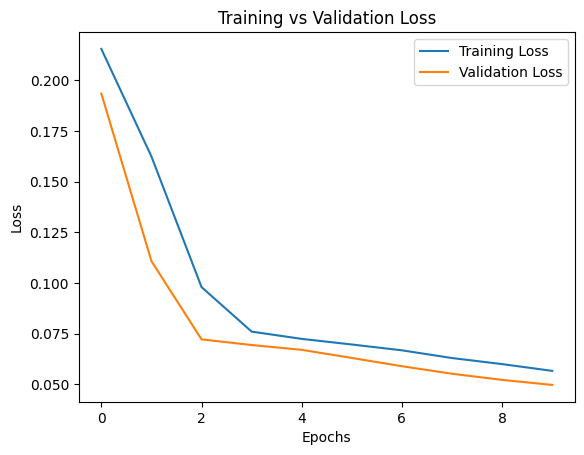

In [83]:
m1.plot_loss()

In [84]:
m1.infer(rpm_data 'rpm')

1/4 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


(array([[0.00565848, 0.00782648, 0.01191767, ..., 0.1461607 , 0.02595181,
         0.14463727],
        [0.02321317, 0.02539   , 0.0313851 , ..., 0.28070349, 0.05200417,
         0.29244325],
        [0.02510093, 0.02303105, 0.01953445, ..., 0.5046421 , 0.0285325 ,
         0.53828955],
        ...,
        [0.03558191, 0.041151  , 0.03742011, ..., 0.42608348, 0.05350909,
         0.3883277 ],
        [0.02119537, 0.02590206, 0.03198965, ..., 0.2174868 , 0.06016297,
         0.22456448],
        [0.02853481, 0.02781262, 0.0360467 , ..., 0.31652686, 0.04964646,
         0.37289575]], dtype=float32),
         BUS ID     Error
 399500    0545  0.062159
 1451441   0350  0.060794
 4533265   0153  0.071457
 3182905   02c0  0.038586
 3041058   018f  0.069450
 ...        ...       ...
 3569638   0350  0.050153
 1208541   02c0  0.033692
 3302000   0440  0.099975
 985131    0350  0.045264
 2352009   0131  0.065031
 
 [100 rows x 2 columns])

In [86]:
#m1.inference_errors['rpm']

,BUS ID,Error
399500,0545,0.062159
1451441,0350,0.060794
4533265,0153,0.071457
3182905,02c0,0.038586
3041058,018f,0.069450
...,...,...
3569638,0350,0.050153
1208541,02c0,0.033692
3302000,0440,0.099975
985131,0350,0.045264


In [24]:
input_dim = X_train.shape[1]   # should be 34
encoding_dim = 16              # latent size (tune this)

input_layer = layers.Input(shape=(input_dim,)) # this is the
encoder = layers.Dense(64, activation="relu")(input_layer)
encoder = layers.Dense(32, activation="relu")(encoder)
latent = layers.Dense(encoding_dim, activation="relu")(encoder)

decoder = layers.Dense(32, activation="relu")(latent)
decoder = layers.Dense(64, activation="relu")(decoder)
output_layer = layers.Dense(input_dim, activation="sigmoid")(decoder)

autoencoder = models.Model(inputs=input_layer, outputs=output_layer)
autoencoder.compile(optimizer="adam", loss="mse")
autoencoder.summary()

Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_3 (InputLayer)      │ (None, 26)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_18 (Dense)                │ (None, 64)             │         1,728 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_19 (Dense)                │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_20 (Dense)                │ (None, 16)             │           528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_21 (Dense)                │ (None, 32)             │           544 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_22 (Dense)                │ (None, 64)             │         2,112 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_23 (Dense)                │ (None, 26)             │         1,690 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 8,682 (33.91 KB)

 Trainable params: 8,682 (33.91 KB)

 Non-trainable params: 0 (0.00 B)